In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm as tqdm
import lightning.pytorch as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from torchmetrics.image.fid import FrechetInceptionDistance
import matplotlib.pyplot as plt


In [2]:
class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        out,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            elif upsampling_layer > num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens // 2, out)
            else:
                raise ValueError(f"Invalid upsampling layer: {upsampling_layer}. In Encoder.")

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return x_recon


class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay**self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3**0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x**2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts**2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
            out_channels

        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
        }


class VQVAE_Trainer(pl.LightningModule):
    def __init__(
        self,
        in_channels=1,
        out_channels=1,
        num_hiddens=64,
        num_downsampling_layers=2,
        num_residual_layers=2,
        num_residual_hiddens=64,
        embedding_dim=16,
        num_embeddings=64,
        use_ema=True,
        decay=0.9,
        epsilon=1e-5,
        beta=1,
        lr=2e-4,
        weight_decay=1e-5,
        fid_features=2048,
        batch_size=64,
    ):
        super(VQVAE_Trainer, self).__init__()
        self.model = VQVAE(
            in_channels=in_channels,
            out_channels=out_channels,
            num_hiddens=num_hiddens,
            num_downsampling_layers=num_downsampling_layers,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
            embedding_dim=embedding_dim,
            num_embeddings=num_embeddings,
            use_ema=use_ema,
            decay=decay,
            epsilon=epsilon,
        )

        self.beta = beta

        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)
        recon_error = F.mse_loss(out["x_recon"], x, reduction="sum")

        loss = recon_error + self.beta * out["commitment_loss"]

        self.log("train_loss", loss)
        self.log("train_recon_error", recon_error)
        self.log("train_commitment_loss", out["commitment_loss"])

        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        recon_error = F.mse_loss(out["x_recon"], x) # , reduction="sum")

        loss = recon_error + self.beta * out["commitment_loss"]

        self.log("val_loss", loss)
        self.log("val_recon_error", recon_error)
        self.log("val_commitment_loss", out["commitment_loss"])

        if batch_idx == 0:
            self.logger.experiment.log(
                {
                    "reconstructed": wandb.Image(
                        torchvision.utils.make_grid(out["x_recon"]),
                        caption=f"Epoch {self.current_epoch}, Step {self.global_step}",
                    ),
                    # "real": wandb.Image(
                    #     torchvision.utils.make_grid(x),
                    #     caption=f"Epoch {self.current_epoch}, Step {self.global_step}",
                    # ),
                }
            )

            # Resize to 299x299
            x = F.interpolate(x, size=299)
            x_hat = F.interpolate(out["x_recon"], size=299)
            
            if x.shape[1] == 1:
                x = x.repeat(1, 3, 1, 1)
                x_hat = x_hat.repeat(1, 3, 1, 1)

            # Convert to u8
            x = (x * 255).to(torch.uint8).cpu()
            x_hat = (x_hat * 255).to(torch.uint8).cpu()

            fid = FrechetInceptionDistance(self.hparams.fid_features)

            # Compute FID
            fid.update(x, real=True)
            fid.update(x_hat, real=False)

            self.log("fid", fid.compute())

    def configure_optimizers(self):
        return optim.AdamW(self.model.parameters(), lr=self.hparams.lr, amsgrad=True, weight_decay=self.hparams.weight_decay)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                "data",
                train=True,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize(32),
                        torchvision.transforms.ToTensor(),
                    ]
                ),
            ),
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=4,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(
                "data",
                train=False,
                download=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize(32),
                        torchvision.transforms.ToTensor(),
                    ]
                ),
            ),
            batch_size=self.hparams.batch_size,
            shuffle=False,
        )


In [3]:
device = "mps"


In [4]:
model = VQVAE_Trainer()
train_loader = model.train_dataloader()
val_loader = model.val_dataloader()
model = model.model.to(device)


In [5]:
print(model(torch.randn(1, 1, 32, 32, device=device))["x_recon"].shape)
print("z_embed:", model.quantize(torch.randn(1, 1, 32, 32, device=device))[0].shape)
print("embed idxs:", model.quantize(torch.randn(1, 1, 32, 32, device=device))[3].shape)
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")


torch.Size([1, 1, 32, 32])
z_embed: torch.Size([1, 16, 8, 8])
embed idxs: torch.Size([1, 64])
Model has 278,289 parameters


In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, amsgrad=True)


z_embed: torch.Size([16, 8, 8])
(16, 64)


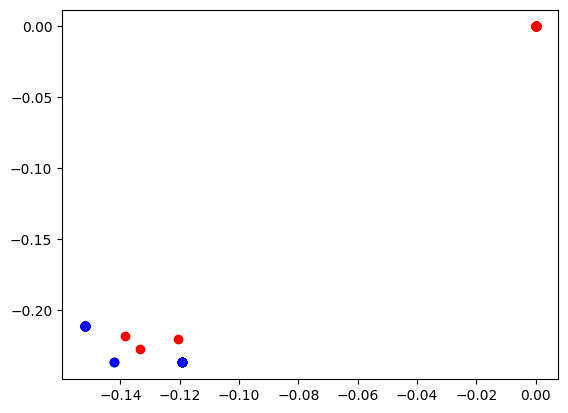

In [7]:

x, y = next(iter(train_loader))

z_embed = model.quantize(x.to(device))[0][0]
embed_idxs = model.quantize(x.to(device))[3][0]

print("z_embed:", z_embed.shape)

for i in range(z_embed.shape[1]):
    for j in range(z_embed.shape[2]):
        # print(z_embed[0, i, j])
        # print(z_embed[1, i, j])
        x = z_embed[0, i, j].cpu().detach()
        y = z_embed[1, i, j].cpu().detach()

        plt.plot(x, y, "o", c="blue")

# Plot model embedding weights
values = model.vq.e_i_ts.cpu().detach().numpy()
print(values.shape)
for i in range(values.shape[1]):
    plt.scatter(values[0][i], values[1][i], label=f"Embedding {i}", c="red")

plt.show()


In [8]:
model.train()
pbar = tqdm.tqdm(range(10), desc="Epochs", unit="epoch")

for epoch in pbar:
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        output = model(x)

        x_recon = output["x_recon"]

        recon_loss = F.mse_loss(x_recon, x)
        dict_loss = output["dictionary_loss"]
        commit_loss = output["commitment_loss"]

        loss = recon_loss + commit_loss # + dict_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(
            {
                "loss": loss.item(),
                # "dict loss": dict_loss.item() if dict_loss is not None else 0,
                "commit loss": commit_loss.item(),
                "recon loss": recon_loss.item(),
            }
        )


Epochs: 100%|██████████| 10/10 [06:06<00:00, 36.62s/epoch, loss=0.00232, commit loss=0.00064, recon loss=0.00168]


z_embed: torch.Size([16, 8, 8])
(16, 64)


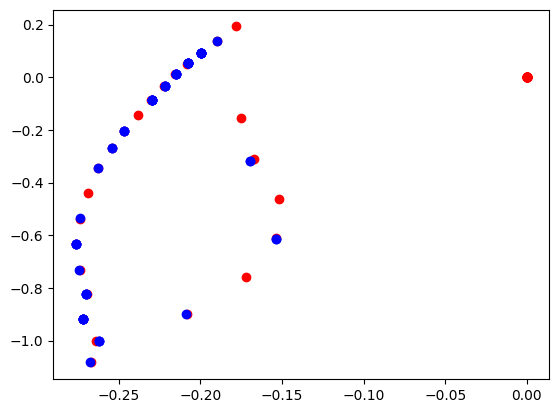

In [9]:
x, y = next(iter(train_loader))

z_embed = model.quantize(x.to(device))[0][0]
embed_idxs = model.quantize(x.to(device))[3][0]

print("z_embed:", z_embed.shape)

for i in range(z_embed.shape[1]):
    for j in range(z_embed.shape[2]):
        # print(z_embed[0, i, j])
        # print(z_embed[1, i, j])
        x = z_embed[0, i, j].cpu().detach()
        y = z_embed[1, i, j].cpu().detach()

        plt.plot(x, y, "o", c="blue")

# Plot model embedding weights
values = model.vq.e_i_ts.cpu().detach().numpy()
print(values.shape)
for i in range(values.shape[1]):
    plt.scatter(values[0][i], values[1][i], label=f"Embedding {i}", c="red")

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


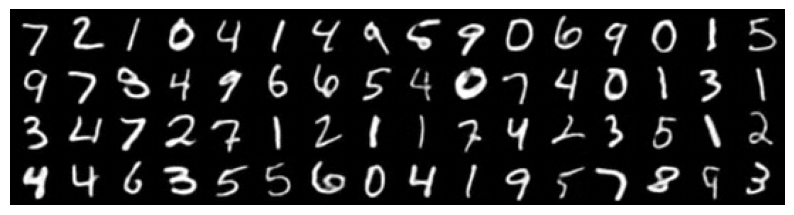

In [14]:
model.eval()
x, _ = next(iter(val_loader))
x = x.to(device)
out = model(x)

plt.figure(figsize=(10, 5))
grid = torchvision.utils.make_grid(out["x_recon"], nrow=16)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off")
plt.show()


In [11]:
torch.save(model.state_dict(), "projects/custom/vq-vae/vq-vae.pth")


In [12]:
# Quantize the images and save the dataset
model.eval()
dataset_x = []
dataset_y = []
for x, y in train_loader:
    x = x.to(device)
    z = model.quantize(x)[3]
    dataset_x.append(z.cpu().detach())
    dataset_y.append(y)

dataset = torch.utils.data.TensorDataset(torch.cat(dataset_x), torch.cat(dataset_y))
torch.save(dataset, "projects/custom/vq-vae/train_mnist_quantized.pth")


In [13]:
# Quantize the images and save the dataset
model.eval()
dataset_x = []
dataset_y = []
for x, y in val_loader:
    x = x.to(device)
    z = model.quantize(x)[3]
    dataset_x.append(z.cpu().detach())
    dataset_y.append(y)

dataset = torch.utils.data.TensorDataset(torch.cat(dataset_x), torch.cat(dataset_y))
torch.save(dataset, "projects/custom/vq-vae/val_mnist_quantized.pth")
